# 1 Importation des données

In [1]:
import os
import tarfile 
from six.moves import urllib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import datetime
import time

import yfinance as yf

# Classe ```Indice``` pour importer les données d'un actif et calculer les indices.

## Présentation de la classe

La classe importe les données depuis YahooFinance.

L'argument `ticker_symbol` suffit lors de l'instanciation. Il s'agit du symbole boursier de l'action dont les données seront téléchargées.\
L'argument `data` lors de l'instanciation permet de donner directement les données si elles sont téléchargées.

La méthode `update` calcule les différents indices qui seront affichés par la méthode `affichage`. Elle est exécutée lors de l'instanciation.

L'historique du prix de l'action est accessible via la méthode `get_data`.\
Les calculs des indices OBV, ADLine, ADX et Aroon sont implémentés et accessibles via la méthode `get_index`.\

## Présentation des indices

### OBV
Il s'agit d'un indicateur de momentum qui mesure les flux de volume positifs et négatifs. 

Si la courbe de l'OBV augmente (ou diminue) de façon prononcée, sans changement significatif du prix de l'actif, cela indique qu'à un moment, le prix devrait sauter vers le haut (ou vers le bas).

Lorsque les institutions commencent à acheter un actif que les particuliers continuent de vendre, le prix est encore légèrement en baisse ou se stabilise, alors que le volume augmente. Le phénomène inverse se produit également. 

### ADLine
L'ADLine (*Accumulative Distribution Line*) est un indicateur qui mesure le flux d'argent pour un actif en prenant en compte à la fois les variations de prix et les volumes.

Une ADLine en hausse indique une pression d'achat accrue, souvent interprétée comme une accumulation de la part des investisseurs, tandis qu'une ADLine en baisse révèle une pression de vente ou une distribution.

Une divergence entre l'ADLine et le prix de l'actif peut être utilisée pour anticiper un retournement potentiel de tendance. Par exemple, si le prix monte mais que l'ADLine chute, cela pourrait signaler un affaiblissement de la tendance haussière.

### ADX
L'ADX identifie une tendance forte lorsqu'il est au-dessus de 25 et une tendance faible lorsqu'il est en-dessous de 20. \
On peut également utiliser le franchissement des lignes $-DI$ et $+DI$ pour générer des signaux de trade: 
- Lorsque $+DI$ passe au-dessus de $-DI$ et que l'ADX est supérieur à 20 (idéalement à 25), alors il s'agit d'un potentiel signal pour acheter.
- Inversement, lorsque $-DI$ passe au-dessus de $+DI$ et que l'ADX est supérieur à 20 (ou 25), il s'agit d'un potentiel signal pour vendre.

### Aroon
Indique si le prix maximal ou minimal a été atteint depuis longtemps ou non sur les dernières périodes (25 par défaut). Il peut s'agir du prix d'ouverture, de clôture, le prix maximal ou minimal sur la période. S'il est à 100, c'est que le prix maximal a été atteint la veille et que le prix minimal a été atteint avant toutes les périodes étudiées. S'il est à -100 dans le cas contraire.

## Formules

### OBV (On-Balance Volume)
$$ 
\text{OBV}_t = \text{OBV}_{t-1} + 
\begin{cases} 
    \text{Volume}_t & \text{if } \text{Close}_t > \text{Close}_{t-1} \\
    -\text{Volume}_t &\text{if } \text{Close}_t < \text{Close}_{t-1} \\ 
    0 & \text{if } \text{Close}_t = \text{Close}_{t-1} 
\end{cases}
$$
$$
\text{OBV}_0 = 0
$$

### ADLine (Accumulation/Distribution Line)
$$
\text{MFM}_t = \frac{(\text{Close}_t - \text{Low}_t) - (\text{High}_t - \text{Close}_t)}{\text{High}_t - \text{Low}_t}
$$
$$
\text{MFV}_t = \text{MFM}_t \times \text{Volume}_t
$$
$$
\text{ADLine}_t = \sum_{i=1}^{t} \text{MFV}_i
$$
### ADX (Average Directional Index)
$$
\text{DM}^+_t = 
\begin{cases} 
    \text{High}_t - \text{High}_{t-1} & \text{if } 
        (\text{High}_t - \text{High}_{t-1}) > (\text{Low}_{t-1} - \text{Low}_t) \text{ and } 
        (\text{High}_t - \text{High}_{t-1}) > 0 \\
     0 & \text{otherwise} 
\end{cases}
$$
$$
\text{DM}^-_t = 
\begin{cases} 
    \text{Low}_{t-1} - \text{Low}_t & \text{if } (\text{Low}_{t-1} - \text{Low}_t) > (\text{High}_t - \text{High}_{t-1}) \text{ and } (\text{Low}_{t-1} - \text{Low}_t) > 0 \\
    0 & \text{otherwise} 
\end{cases}
$$
$$
\text{TR}_t = \max(\text{High}_t - \text{Low}_t,\; |\text{High}_t - \text{Close}_{t-1}|,\; |\text{Low}_t - \text{Close}_{t-1}|)
$$
$$
\text{DI}^+_t = 100 \times \frac{\text{DM}^+_t}{\text{TR}_t} \qquad \qquad
\text{DI}^-_t = 100 \times \frac{\text{DM}^-_t}{\text{TR}_t}
$$
$$
\text{DX}_t = 100 \times \frac{|\text{DI}^+_t - \text{DI}^-_t|}{\text{DI}^+_t + \text{DI}^-_t}
$$
$$
\text{ADX}_t = \frac{1}{n} \sum_{i=t-n+1}^{t} \text{DX}_i
$$
### Aroon
$$
\text{Aroon}^{Up}_t = 100 \times \frac{n - \text{Periods since last High}_t}{n}
$$
$$
\text{Aroon}^{Down}_t = 100 \times \frac{n - \text{Periods since last Low}_t}{n}
$$
$$
\text{Aroon}_t = \text{Aroon}^{Up}_t - \text{Aroon}^{Down}_t
$$
avec $n = 10$ ou $n = 14$ pour une analyse à court terme, et $n = 50$ ou $n = 100$ pour une analyse à long terme. \
Il s'agit de la période utilisée pour calculer les dates du dernier maximum et minimum du prix.

In [29]:
ticker = yf.Ticker('AAPL')
data_hist = ticker.history(period = '10y')
dates = pd.Series(data_hist['Open'].index).apply(lambda x: pd.to_datetime(x.strftime('%Y-%m-%d')))

data_apple = data_hist.reset_index(drop = True).set_index(dates)#.drop(['Dividends', 'Stock Splits'], axis = 1)

In [30]:
class Index():
    """
    A class to represent and calculate various financial indices for a given stock.
    """

    @staticmethod
    def load_data(ticker_symbol='AAPL', period='10y'):
        """
        Import stock price history.
        
        IN: ticker_symbol: <str> Stock identifier
            period: <str> Period over which data is downloaded
                    arg: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
        OUT: <pd.Series>: Stock history
        """
        ticker = yf.Ticker(ticker_symbol)  # Create a Ticker object
        data_hist = ticker.history(period=period)  # Download historical data
        dates = pd.Series(data_hist['Open'].index).apply(lambda x: pd.to_datetime(x.strftime('%Y-%m-%d')))  # Convert dates
        data = data_hist.reset_index(drop=True).set_index(dates).drop(['Dividends', 'Stock Splits'], axis=1)  # Prepare data
        return data

    @classmethod
    def smooth(cls, series, period=14, method='simple', fill='NoFill', alpha=1/14):
        """
        Calculate moving average.
        
        IN: series: <Pandas Series> Series for which the moving average is calculated
            period: <int> Number of periods used for the moving average
            method: <str> Method used for calculating the average
                    'simple': Calculate arithmetic average
                    'exp': Calculate exponential average
                    'weight': Assign increasing weights to series and calculate arithmetic average
            fill: <str> If the first period values are initialized or left empty (fill='NoFill')
                  'constant': Fill with the first non-null value (at position period)
                  'data': Fill with the first period values of the series
                  'smooth': Fill value i with the moving average of the first i+1 values of the series over a period of i+1, 
                            for i from 1 to period - 1. The same method of calculating the average is used.
            alpha: <int> Argument for calculating the average by the 'exp' method. Must be between 0 and 1.
        OUT: <Pandas Series>: Smoothed series
        """
        match method:
            case 'simple':
                smoothed = series.rolling(period).sum().copy() / period  # Simple moving average
            case 'exp':
                smoothed = [series.iloc[0]]  # Initialize with the first value
                for i in range(1, len(series)):
                    smoothed += [alpha * series.iloc[i] + (1 - alpha) * smoothed[i - 1]]  # Exponential moving average
                smoothed = pd.Series(smoothed)
            case 'weight':
                weight = np.array([k for k in range(1, period + 1)])  # Weights for weighted moving average
                smoothed = series.rolling(period).apply(lambda x: np.dot(x, weight).sum() / weight.sum())  # Weighted moving average
        
        match fill:
            case 'constant':
                smoothed.iloc[:period] = smoothed.iloc[period - 1]  # Fill with constant value
            case 'data':
                smoothed.iloc[:period - 1] = series.iloc[:period - 1]  # Fill with initial data values
            case 'smooth':
                smoothed.iloc[0] = series.iloc[0]  # Initialize with the first value
                for i in range(1, period):
                    smoothed.iloc[i] = cls.smooth(series=series.iloc[:i + 1], period=i + 1, method=method, fill='NoFill').iloc[i]  # Smooth fill
            case 'NoFill':
                pass  # No fill

        return smoothed

    def __init__(self, ticker_symbol='AAPL', data=False) -> None:
        """
        Initialize the Index class.
        
        IN: ticker_symbol: <str> Stock ticker symbol to study
            data: <bool or Pandas DataFrame> If data is False, the history will be downloaded from Yahoo Finance. 
                                             Otherwise, data must contain the data downloaded from Yahoo Finance and 
                                             transformed as in the static method load_data.
        """
        self.__TICKER_SYMBOL = ticker_symbol  # Stock ticker symbol
        self.__data = None  # Data placeholder
        self.__index = None  # Index placeholder
        self.__date_limits = {'Start': None, 'End': None}  # Date limits

        self.__start(data)  # Initialize data
    
    def __start(self, data):
        """Start the data initialization."""
        if data is not False:
            self.__data = data  # Use provided data
        else:
            self.__data = self.load_data(ticker_symbol = self.__TICKER_SYMBOL)  # Load data from Yahoo Finance

        self.__index = pd.DataFrame(index = self.__data.index)  # Initialize index DataFrame
        self.__date_limits['Start'] = self.__data.index[0]  # Set start date
        self.__date_limits['End'] = self.__data.index[-1]  # Set end date
    
    def get_data(self):
        """Return the data."""
        return self.__data
    
    def get_index(self):
        """Return the index."""
        return self.__index
        
    def update(self, **kwargs):
        """Update the index with calculated indicators."""
        self.__index = pd.DataFrame(index=self.__data.index)  # Reset index DataFrame
        self.OBV(**kwargs)
        self.ADLine(**kwargs)
        self.ADX(**kwargs)
        self.Aroon(**kwargs)
    
    def add(self, indicator, dates, **kwargs):
        """Add a specific indicator to the index."""
        match indicator:
            case 'C': return self.C(dates=dates, **kwargs)  # Add indicator 'C'

    # Display methods
    def display(self, start_date, end_date, list_indices, **kwargs):
        """
        Display the graphs of the specified indices in list_indices.
        
        IN: start_date, end_date: <str> Start and end dates for displaying the indices
            list_indices: <list of str> List of indices in string format to display. 
                         Multiple lists will give multiple graphs. 
                         Different indices within a single list will be displayed on the same graph.
                         Index names: 'OBV', 'ADLine', 'ADX'
            **kwargs: Arguments to pass to the index calculation methods
        """
        self.update(**kwargs)  # Update indices

        # Convert start and end date
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)

        if start < self.__date_limits['Start']: start = self.__date_limits['Start']  # Adjust start date
        else: pass
        if end > self.__date_limits['End']: end = self.__date_limits['End']  # Adjust end date
        else: pass

        data = self.__index.loc[start:end]  # Filter data by date range
        x = pd.Series(data.index).apply(lambda x: x.strftime('%d/%m/%y'))  # Format dates for x-axis

        fig, ax = plt.subplots(len(list_indices), 1, figsize=(20, 3 * len(list_indices)))  # Create subplots
        fig.suptitle(f'Period {start.strftime("%d/%m/%y")} - {end.strftime("%d/%m/%y")}')  # Set title
        for i, indices in enumerate(list_indices):
            for indicator in indices:
                if indicator in data:
                    y = data[indicator]  # Get data for the index if present
                else:
                    y = self.__add(indicator, dates=data.index, **kwargs)  # Add index data if not present
                style = kwargs.get(f'{indicator}_style', '')  # Get style for the index
                ax[i].plot(x, y, style, label=indicator)  # Plot the index
            ax[i].legend()
            ax[i].set_xticks(ticks=x.iloc[np.linspace(0, 1, 20) * (len(x) - 1)])
    
    # Index calculation methods
    def OBV(self, start='Close', end=False, **kwargs):
        """
        Calculate the On-Balance Volume (OBV) indicator.
        
        IN: start, end: <str> Among 'Open' and 'Close', the directions for adding volumes will be calculated according 
                        to the opening price ('Open') or closing price ('Close') of day n for the start and day n+1 for the end.
            **kwargs: Exists for compatibility
        OUT: <Pandas Series>: OBV indicator
        """
        if start == 'Open' and end == 'Close':
            direction = self.__data[end] - self.__data[start]  # Calculate direction based on Open and Close
        elif end:
            direction = self.__data[end] - self.__data[start].shift(1)  # Calculate direction based on shifted Close
        else: direction = self.__data[start] - self.__data[start].shift(1)  # Calculate direction based on shifted Open

        direction.iloc[0] = 1  # Set initial direction
        OBV = (self.__data['Volume'] * direction / abs(direction)).cumsum()  # Calculate OBV
        self.__index['OBV'] = np.where(np.isnan(OBV), OBV.shift(1), OBV)  # Handle NaN values and store OBV

        return self.__index['OBV']
        
    def ADLine(self, **kwargs):
        """
        Calculate the Accumulation/Distribution Line (ADLine) indicator.
        
        IN: **kwargs: Exists for compatibility
        OUT: <Pandas Series>: ADLine indicator
        """
        MFM = ((self.__data['High'] - 2 * self.__data['Close'] + self.__data['Low'])) / \
              (self.__data['Low'] - self.__data['High'])  # Money Flow Multiplier
        MFV = MFM * self.__data['Volume']  # Money Flow Volume

        self.__index['ADLine'] = MFV.cumsum()  # Calculate and store ADLine

        return self.__index['ADLine']
    
    def ADX(self, period_ADX=14, method='exp', fill='NoFill', alpha=1/14, **kwargs):
        """
        Calculate the Average Directional Index (ADX) indicator.
        
        IN: period_ADX: <int> Number of periods used for the ADX calculation
            method: <str> Method used for calculating the average
                    'simple': Calculate arithmetic average
                    'exp': Calculate exponential average
                    'weight': Assign increasing weights to series and calculate arithmetic average
            fill: <str> If the first period values are initialized or left empty (fill='NoFill')
                  'constant': Fill with the first non-null value (at position period)
                  'data': Fill with the first period values of the series
                  'smooth': Fill value i with the moving average of the first i+1 values of the series over a period of i+1, 
                            for i from 1 to period - 1. The same method of calculating the average is used.
            alpha: <int> Argument for calculating the average by the 'exp' method. Must be between 0 and 1.
            **kwargs: Exists for compatibility
        OUT: <Pandas Series>: ADX indicator
        """
        DMp = np.where(self.__data['High'] - self.__data['High'].shift(1) > self.__data['Low'].shift(1) - self.__data['Low'],
                       self.__data['High'] - self.__data['High'].shift(1), 0)  # Positive Directional Movement
        DMm = np.where(self.__data['High'] - self.__data['High'].shift(1) <= self.__data['Low'].shift(1) - self.__data['Low'],
                       self.__data['Low'].shift(1) - self.__data['Low'], 0)  # Negative Directional Movement

        TR = pd.DataFrame([self.__data['High'] - self.__data['Low'], 
                           self.__data['High'] - self.__data['Close'].shift(1), 
                           self.__data['Close'].shift(1) - self.__data['Low']]).apply(max)  # Set True Range

        # Smoothed Positive DM, Negative DM and True Range
        DMpsmooth = self.smooth(series=pd.Series(DMp), period=period_ADX, method=method, fill=fill, alpha=alpha)
        DMmsmooth = self.smooth(series=pd.Series(DMm), period=period_ADX, method=method, fill=fill, alpha=alpha)
        TRsmooth = self.smooth(series=pd.Series(TR), period=period_ADX, method=method, fill=fill, alpha=alpha)

        DIp = 100 * DMpsmooth / TRsmooth  # Positive Directional Indicator
        DIm = 100 * DMmsmooth / TRsmooth  # Negative Directional Indicator

        DX = 100 * (DIp - DIm) / (DIp + DIm)  # Directional Movement Index
        DX.iloc[0] = 0  # Set initial DX
        ADX = self.smooth(DX, period=period_ADX, method=method, fill=fill, alpha=alpha)  # Average Directional Index

        # Set index for ADX, DIp, DIm
        ADX.index = self.__index.index
        DIp.index = self.__index.index
        DIm.index = self.__index.index
        
        # Store ADX, Positive DI and Negative DI in index
        self.__index['ADX'] = ADX
        self.__index['pDI'] = DIp
        self.__index['mDI'] = DIm
        
        return self.__index['ADX']
    
    def Aroon(self, period_Aroon=25, event='Close', **kwargs):
        """
        Calculate the Aroon indicator.
        
        IN: period_Aroon: <int> Number of periods over which the index is calculated
            event: <str> Among 'Open', 'Close', 'Low', and 'High', the Aroon index will be calculated based on the variations of these events.
            **kwargs: Exists for compatibility
        OUT: <Pandas Series>: Aroon indicator
        """
        def indMin(i):
            if i < period_Aroon: start, end = 0, max(i, 1)
            else: start, end = i - period_Aroon, i
            return np.argmin(self.__data[event].iloc[start: end])  # Index of minimum value
        def indMax(i):
            if i < period_Aroon: start, end = 0, max(i, 1)
            else: start, end = i - period_Aroon, i
            return np.argmax(self.__data[event].iloc[start: end])  # Index of maximum value

        # Calculate argMin, argMax and Aroon indicator for each period
        argMin = pd.Series(range(len(self.__data))).apply(indMin)
        argMax = pd.Series(range(len(self.__data))).apply(indMax)
        Aroon = 100 * (argMin - argMax) / period_Aroon
        
        # Store Aroon in index
        Aroon.index = self.__index.index
        self.__index['Aroon'] = Aroon

        return self.__index['Aroon']
    
    # Other lines
    def C(self, dates, c=25):
        """
        Generate a horizontal curve.
        
        IN: dates: <Pandas Index> Dates for the curve
            c: <int> Height of the curve
        OUT: <Pandas Series>: Horizontal curve
        """
        return pd.Series(range(len(self.__index.index)), index=dates)
    
apple = Index(data=data_apple)  # Test the Index class with Apple data


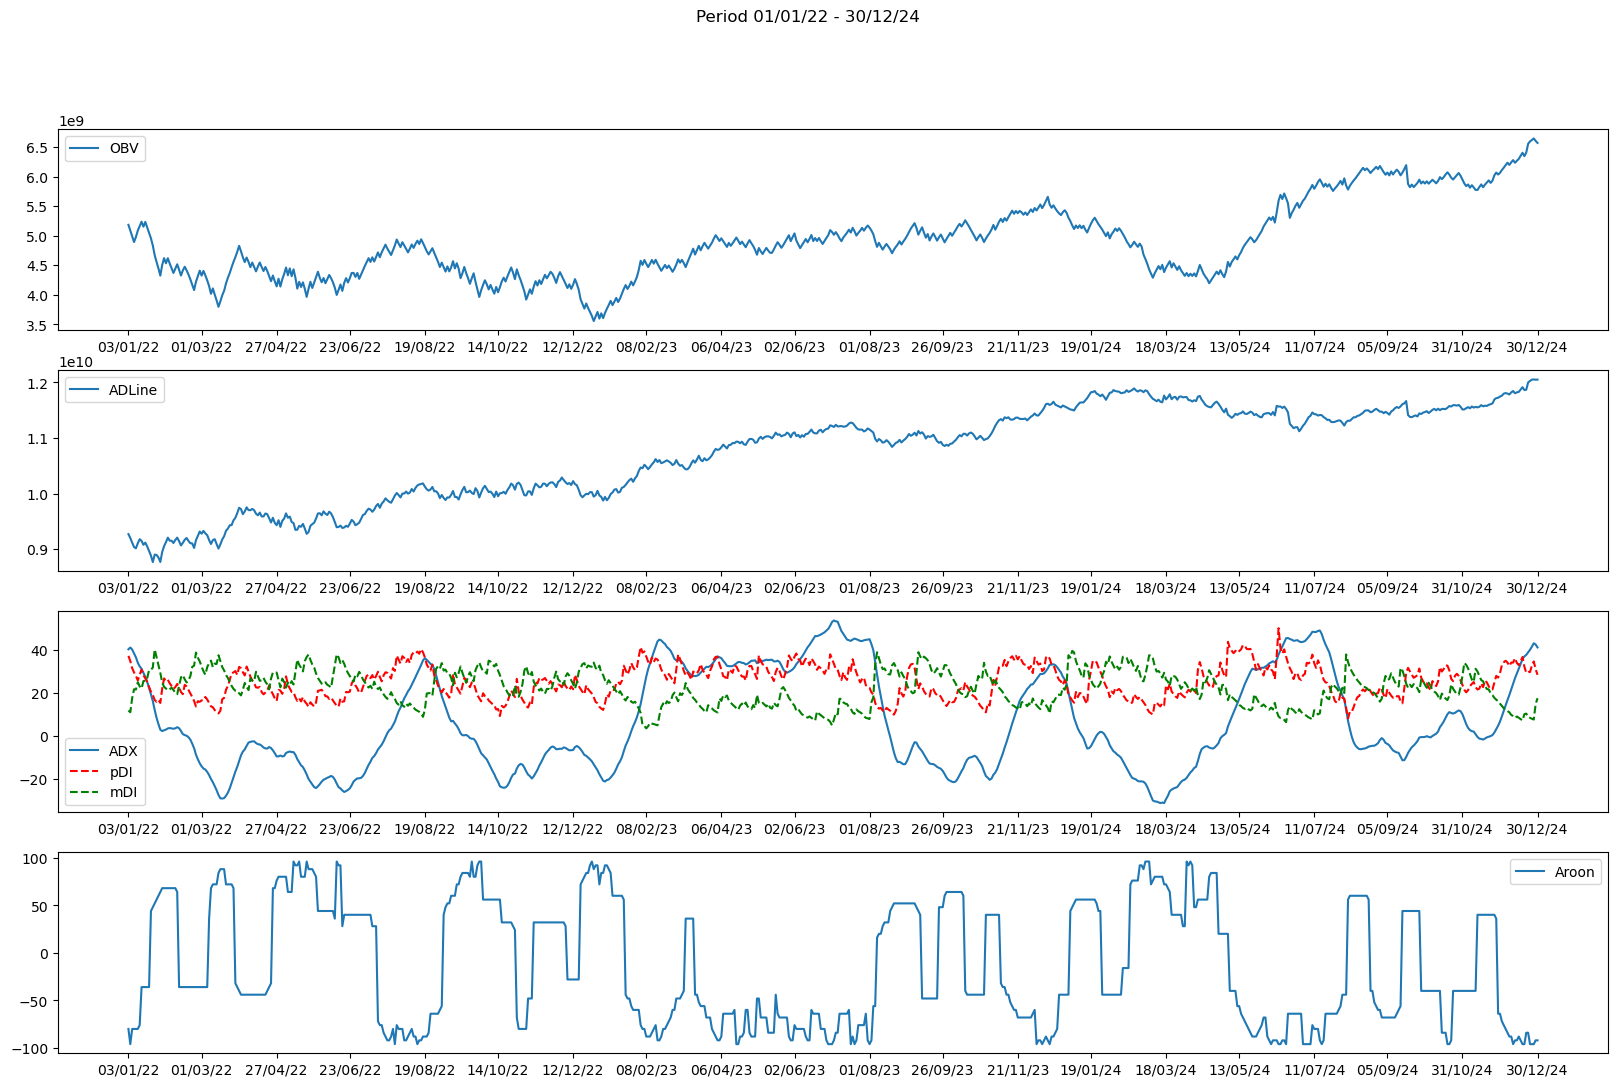

In [31]:
YEAR = 2022
DELTA = 10
BEGIN = str(YEAR) + '-01-01'
END = str(YEAR + DELTA) + '-12-31'

apple.display(start_date = BEGIN, end_date = END, 
               list_indices = [['OBV', ], ['ADLine', ], ['ADX', 'pDI', 'mDI'], ['Aroon', ]], 
               ADX_color = 'b', pDI_style = 'r--', mDI_style = 'g--')

In [34]:
df = apple.get_index().T

In [36]:
df.columns.name = None
df.head()

,2014-12-31,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2024-12-16,2024-12-17,2024-12-18,2024-12-19,2024-12-20,2024-12-23,2024-12-24,2024-12-26,2024-12-27,2024-12-30
OBV,1.656136e+08,-4.720480e+07,-3.043468e+08,-4.115840e+07,1.192652e+08,3.567232e+08,5.715212e+08,3.729180e+08,6.412856e+08,4.454592e+08,...,6.351102e+09,6.402458e+09,6.345684e+09,6.406566e+09,6.554062e+09,6.594920e+09,6.618155e+09,6.645392e+09,6.603075e+09,6.569077e+09
ADLine,-1.463300e+08,-1.530943e+08,-2.769039e+08,-2.336652e+08,-1.694951e+08,3.217188e+07,7.174029e+07,-8.019400e+07,-1.678105e+08,-1.077824e+08,...,1.187235e+10,1.191483e+10,1.186344e+10,1.186952e+10,1.200085e+10,1.202760e+10,1.205067e+10,1.205409e+10,1.204974e+10,1.205159e+10
ADX,0.000000e+00,-7.142857e+00,-1.377551e+01,-1.993440e+01,-2.363761e+01,-2.170137e+01,-1.910281e+01,-1.782147e+01,-1.650430e+01,-1.559578e+01,...,3.357424e+01,3.596361e+01,3.711173e+01,3.785344e+01,3.902701e+01,4.021237e+01,4.166326e+01,4.323818e+01,4.266906e+01,4.130578e+01
pDI,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.851485e+00,1.084454e+01,1.263659e+01,1.153019e+01,1.090447e+01,1.040355e+01,...,3.480112e+01,3.686210e+01,3.234937e+01,2.943580e+01,2.986884e+01,2.985653e+01,3.282557e+01,3.478488e+01,3.115456e+01,2.854885e+01
mDI,0.000000e+00,6.801487e+00,1.069602e+01,1.182142e+01,1.126997e+01,1.011722e+01,9.401697e+00,1.180179e+01,1.077035e+01,1.122207e+01,...,7.912087e+00,7.277402e+00,1.020515e+01,1.047835e+01,8.850608e+00,8.514031e+00,8.072244e+00,7.710264e+00,1.490807e+01,1.765301e+01
